In [1]:
import os
import re
import json
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import spacy
from spacy.matcher import Matcher

from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

In [5]:
debug = False
articles = {}
stat = { }
for dirpath, subdirs, files in os.walk(r'C:\Users\hugomeyer\Documents\Hackathon\Input'):
    for x in files:
        if x.endswith(".json"):
            articles[x] = os.path.join(dirpath, x)        
df = pd.read_csv(r'C:\Users\hugomeyer\Documents\Hackathon\Input\metadata.csv')


C:\Users\hugomeyer\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
virus_ref = ['covid-19', 'coronavirus', 'cov-2', 'sars-cov-2', 'sars-cov', 'hcov', '2019-ncov']
symptoms = ['weight loss','chills','shivering','convulsions','deformity','discharge','dizziness','vertigo','fatigue','malaise','asthenia','hypothermia','jaundice','muscle weakness','pyrexia','sweats','swelling','swollen','painful lymph node','weight gain','arrhythmia','bradycardia','chest pain','claudication','palpitations','tachycardia','dry mouth','epistaxis','halitosis','hearing loss','nasal discharge','otalgia','otorrhea','sore throat','toothache','tinnitus','trismus','abdominal pain','fever','bloating','belching','bleeding','blood in stool','melena','hematochezia', 'constipation','diarrhea','dysphagia','dyspepsia','fecal incontinence','flatulence','heartburn','nausea','odynophagia','proctalgia fugax','pyrosis','steatorrhea','vomiting','alopecia','hirsutism','hypertrichosis','abrasion','anasarca','bleeding into the skin','petechia','purpura','ecchymosis and bruising','blister','edema','itching','laceration','rash','urticaria','abnormal posturing','acalculia','agnosia','alexia','amnesia','anomia','anosognosia','aphasia and apraxia','apraxia','ataxia','cataplexy','confusion','dysarthria','dysdiadochokinesia','dysgraphia','hallucination','headache','akinesia','bradykinesia','akathisia','athetosis','ballismus','blepharospasm','chorea','dystonia','fasciculation','muscle cramps','myoclonus','opsoclonus','tic','tremor','flapping tremor','insomnia','loss of consciousness','syncope','neck stiffness','opisthotonus','paralysis and paresis','paresthesia','prosopagnosia','somnolence','abnormal vaginal bleeding','vaginal bleeding in early pregnancy', 'miscarriage','vaginal bleeding in late pregnancy','amenorrhea','infertility','painful intercourse','pelvic pain','vaginal discharge','amaurosis fugax','amaurosis','blurred vision','double vision','exophthalmos','mydriasis','miosis','nystagmus','amusia','anhedonia','anxiety','apathy','confabulation','depression','delusion','euphoria','homicidal ideation','irritability','mania','paranoid ideation','suicidal ideation','apnea','hypopnea','cough','dyspnea','bradypnea','tachypnea','orthopnea','platypnea','trepopnea','hemoptysis','pleuritic chest pain','sputum production','arthralgia','back pain','sciatica','Urologic','dysuria','hematospermia','hematuria','impotence','polyuria','retrograde ejaculation','strangury','urethral discharge','urinary frequency','urinary incontinence','urinary retention']
organs = ['mouth','teeth','tongue','salivary glands','parotid glands','submandibular glands','sublingual glands','pharynx','esophagus','stomach','small intestine','duodenum','Jejunum','ileum','large intestine','liver','Gallbladder','mesentery','pancreas','anal canal and anus','blood cells','respiratory system','nasal cavity','pharynx','larynx','trachea','bronchi','lungs','diaphragm','Urinary system','kidneys','Ureter','bladder','Urethra','reproductive organs','ovaries','Fallopian tubes','Uterus','vagina','vulva','clitoris','placenta','testes','epididymis','vas deferens','seminal vesicles','prostate','bulbourethral glands','penis','scrotum','endocrine system','pituitary gland','pineal gland','thyroid gland','parathyroid glands','adrenal glands','pancreas','circulatory system','Heart','patent Foramen ovale','arteries','veins','capillaries','lymphatic system','lymphatic vessel','lymph node','bone marrow','thymus','spleen','tonsils','interstitium','nervous system','brain','cerebrum','cerebral hemispheres','diencephalon','the brainstem','midbrain','pons','medulla oblongata','cerebellum','the spinal cord','the ventricular system','choroid plexus','peripheral nervous system','nerves','cranial nerves','spinal nerves','Ganglia','enteric nervous system','sensory organs','eye','cornea','iris','ciliary body','lens','retina','ear','outer ear','earlobe','eardrum','middle ear','ossicles','inner ear','cochlea','vestibule of the ear','semicircular canals','olfactory epithelium','tongue','taste buds','integumentary system','mammary glands','skin','subcutaneous tissue']
higher_terms = ['over', 'above', 'higher', 'older', '>', 'over', 'less']
lower_terms = ['under', 'below', 'fewer', 'younger', '<', 'under', 'more']

In [8]:
matchers = {    
    "Term Matcher": lambda term: [{'LOWER': t} for t in term.split(' ')],
    "Terms Matcher": lambda terms: [{"LOWER": {"IN": terms } }],
    "Number Suffix Matcher": lambda periods: [
        {'LIKE_NUM': True},
        {"TEXT": {"REGEX": f'({"|".join(periods)})'}}
    ],
    "Number Interval Matcher": lambda periods: [
        {'POS': 'NUM',},
        {'TEXT': {'REGEX': f'({"|".join(periods)})'}, 'OP': '?'},
        {'DEP': 'quantmod', 'OP': '?'},
        {'DEP': 'punct', 'OP': '?'},
        {'DEP': 'prep', 'OP': '?'},
        {'POS': 'NUM'},
        {'TEXT': {'REGEX': f'({"|".join(periods)})'}},
    ],
    "Group Matcher": [
        {"TEXT": {"IN": higher_terms+lower_terms }}
    ]                 
}

In [9]:
def plot_dict(stat, t = 10, sort_values = False, barh = False, width = 20, height = 4, title = ''):
    filtered = dict(stat)
    to_delete = []
    for key in filtered:
        if filtered[key] < t:
            to_delete.append(key)
    for key in to_delete:
        del filtered[key]

    
    if sort_values == False:
        lists = sorted(filtered.items())
    else:
        if sort_values == True:
            lists = sorted(filtered.items(), key = lambda item : item[1])
        else:
            lists = sorted(filtered.items(), key = sort_values)
               
    fig = figure(num=None, figsize=(width, height))
    
    if title != '':
        fig.suptitle(title, fontsize=20)
        
    x, y = zip(*lists) 
    
    if barh == True:
        plt.barh(x, y)
    else:
        plt.bar(x, y)
    plt.show()
    

def merge_keys(mergers, obj):
    result = dict(obj)
    for key, arr in mergers:
        if key not in result:
            result[key] = 0
        for merger in arr:
            if merger in result:
                result[key] = result[key] + result[merger]
                del result[merger]
    return result

def dict_counter(res, arg):
    try:
        key = str(arg)
        res.setdefault(key, 0)
        res[key] = res[key] + 1
    except:
        pass

def numval(val):
    try:
        return int(float(str(val))) 
    except:
        return None
    
def day_value(val, rep = None):
    
    if rep != None:
        val = numval(val.text)
        if val != None and 'week' in rep.text:
            val = val * 7
        return val
    else:
        return None

def report_interval(res, min_val, max_val):       
    if min_val != None and max_val != None:
        for key in range(min_val, max_val):
            res.setdefault(key, 0)
            res[key] = res[key] + 1    

def virus_match(text):
    return len(re.findall(rf'({"|".join(virus_ref)})', text, flags=re.IGNORECASE)) > 0

In [10]:
literature = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    sha = str(row['sha'])
    if sha != 'nan':
        sha = sha + '.json';
        try:
            found = False
            with open(articles[sha]) as f:
                data = json.load(f)
                for key in ['abstract', 'body_text']:
                    if found == False and key in data:
                        for content in data[key]:
                            text = content['text']
                            if virus_match(text) == True:                                
                                literature.append({'file': articles[sha], 'body': text})                                
        except KeyError:
            pass

100%|████████████████████████████████████████████████████████████████████████████| 47298/47298 [08:39<00:00, 91.05it/s]


In [13]:
print(df.iloc[0])

cord_uid                                                                8q5ondtn
sha                                                                          NaN
source_x                                                                Elsevier
title                          Intrauterine virus infections and congenital h...
doi                                                 10.1016/0002-8703(72)90077-4
pmcid                                                                        NaN
pubmed_id                                                            4.36154e+06
license                                                                els-covid
abstract                       Abstract The etiologic basis for the vast majo...
publish_time                                                          1972-12-31
authors                                                        Overall, James C.
journal                                                   American Heart Journal
Microsoft Academic Paper ID 

In [14]:
def execute_matches(match_arr, root, sentence, file, index = 0, execution = []):
    key, result = match_arr[0]
    rest = match_arr[1:]
    next_exec = execution + [(key, result, index)]
    if key in root:
        rule = root[key]
        if callable(rule):
            rule( (result, next_exec, sentence, file) )            
        else:
            if 'execute' in rule:
                rule['execute']( (result, next_exec, sentence, file) )
            if len(rest) > 0:
                execute_matches(rest, rule, sentence, file, index+1, next_exec)
    
    if len(rest) > 0:               
        execute_matches(rest, root, sentence, file, index + 1, execution)
        
def merge_dict_values(original, rules, drop = []):
    result = {}
    arr_map = {}
    for key, values in rules:
        for val in values:
            arr_map[val] = key
    
    for key in original.keys():
        new_key = key if key not in arr_map else arr_map[key]        
        if key not in drop and new_key not in drop:
            val = original[key]            
            result[new_key] = val if new_key not in result else result[new_key] + val
            
    return result
    
def merge_matches(matches, doc):
    match_list = []
    current = (None, None, None)
    for match_id, start, end in matches:   
        if match_id != current[0] or current[2] < start:
            if current[0] != None:
                match_list.append(current)
            current = (match_id, start, end)
        elif current[2] < end:
            current = (match_id, current[1], end)
        
    match_list.append(current)
    return match_list;

def match_parser(matcher, doc, rule, file):
    matches = matcher(doc)
    if len(matches)>0:
        to_process = []
        for match_id, start, end in merge_matches(matches, doc):
            string_id = nlp.vocab.strings[match_id]  # Get string representation
            span = doc[start:end]  # The matched span
            to_process.append((string_id, span))
        execute_matches(to_process, rule['root'], doc, file)

def parse_body(matcher, text, rule, file = None, sentence_level = False):
    text = text.lower()
    doc = nlp(text)
    
    if sentence_level == True:    
        for sent in doc.sents:
            sent_doc = nlp(sent.text)
            match_parser(matcher, sent_doc, rule, file)
    else:
        match_parser(matcher, doc, rule, file)

def execute_ruleset(term, rule, sentence_level = False, literature = literature):
    matcher = Matcher(nlp.vocab)
    for name, m in rule["Matchers"]:
        matcher.add(name, None, m)
    
    for article in tqdm(literature):
#     for article in literature:
        text_list = re.compile("\. ").split(article['body'])
        file = article['file']
        for text in text_list:
            if callable(term):
                allow = term(text)
            else:
                allow = term == None or term in text
            if allow == True:
                parse_body(matcher, text, rule, file, sentence_level)        

In [17]:
print(df.iloc[1, :])

print(articles[aecbc613ebdab36753235197ffb4f35734b5ca63])

cord_uid                                                                pzfd0e50
sha                                                                          NaN
source_x                                                                Elsevier
title                                          Coronaviruses in Balkan nephritis
doi                                                 10.1016/0002-8703(80)90355-5
pmcid                                                                        NaN
pubmed_id                                                            6.24385e+06
license                                                                els-covid
abstract                                                                     NaN
publish_time                                                          1980-03-31
authors                        Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...
journal                                                   American Heart Journal
Microsoft Academic Paper ID 

100%|███████████████████████████████████████████████████████████████████████████| 79364/79364 [04:33<00:00, 289.86it/s]


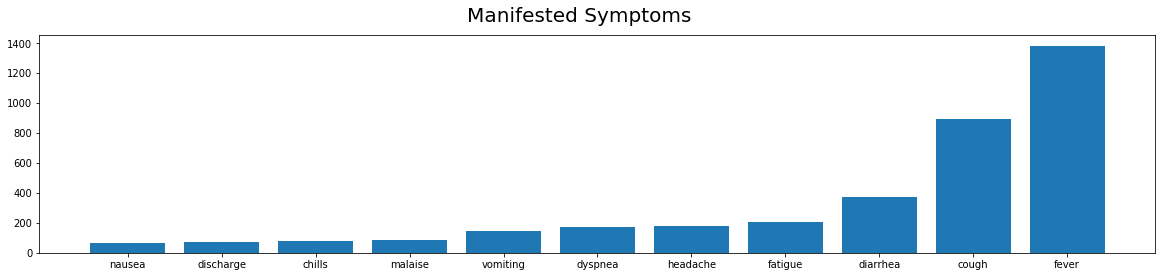

In [15]:
stat['symptoms'] = {}

def match(text):
    if virus_match(text) == True:
        return len(re.findall(rf'\ ({"|".join(symptoms)})\ ', text)) > 0
    else:
        return False

def symptom(res):
    ref, agregate, sentence, file = res
    dict_counter(stat['symptoms'], ref.text)
        
rule = {    
    "Matchers": [      
       ("Symptoms Reference", matchers['Terms Matcher'](symptoms)),
    ],
    "root": {
        "Symptoms Reference": symptom
    }
}


def symptom_match(text):
    return len(re.findall(r'symptom', text)) > 0

execute_ruleset(symptom_match, rule)
plot_dict(stat['symptoms'], 50, True, title = "Manifested Symptoms")